In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
import scipy

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, sns, sklearn, pd:
    print(mod.__name__, mod.__version__)

Environment specification:

python 3.10.13
numpy 1.26.4
scipy 1.11.4
seaborn 0.12.2
sklearn 1.2.2
pandas 2.2.2


**Reading CSV file as Dataframe:**

In [4]:
# kaggle train data
data_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
# kaggle test data
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [5]:
#Concating the train data (data_df) and test data (test_df) to 'all_data'
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


**Exploratory Data Analysis and Data Cleaning**

In [6]:
# Basic summary:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: >

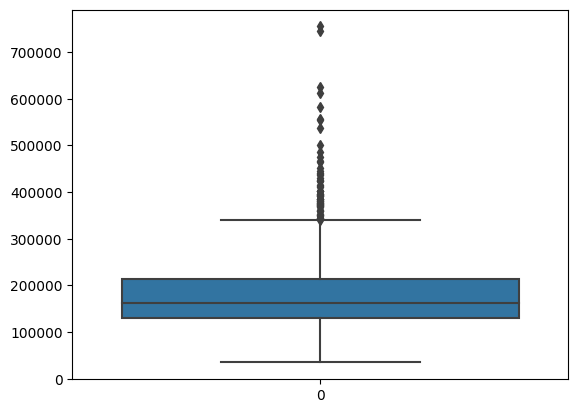

In [7]:
sns.boxplot(data_df['SalePrice'])

There are two outliers with prices more than 700000.

<Axes: xlabel='SalePrice', ylabel='Density'>

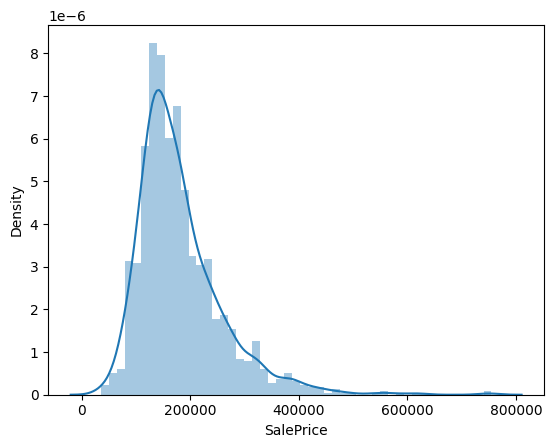

In [8]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

I noticed that it is right-skewed distribution with the pick around 160k and quite long tail with maximum about 800k.

In [9]:
# Positive Skeweness:
data_df['SalePrice'].skew()

1.8828757597682129

In order to be SalePrice more normal let's do Logarithm transformation.

Text(0.5, 1.0, 'Density plot of SalePrice after Log Transformation')

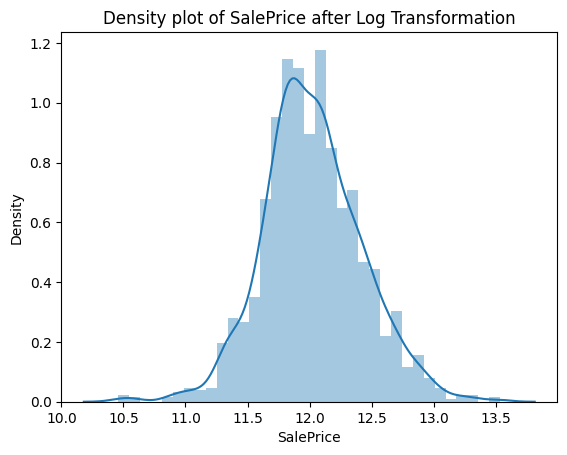

In [10]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])
# SalePrice after Log-transformation
sns.distplot(data_df["SalePrice"])
plt.title("Density plot of SalePrice after Log Transformation")

In [11]:
y_train = data_df["SalePrice"]

 **Columns with Nan values**

At first, I am checking the fraction of Nan values in each column.

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

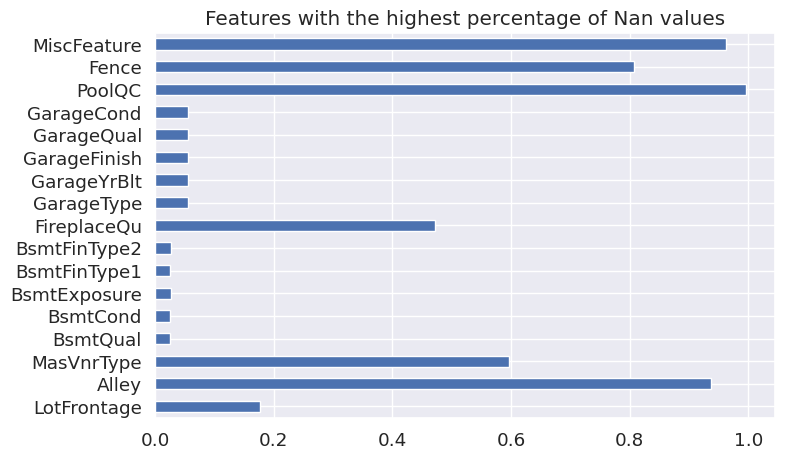

In [12]:
col_nan = data_df.isna().sum() / data_df.shape[0]
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

**Removing Id column**

In [13]:
# Dropping columns for both train and test dataset
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

**Removing columns that contain the same value in 100%**

In [14]:
data_df = data_df.drop(['Street', 'Utilities'], axis=1)
test_df = test_df.drop(['Street', 'Utilities'], axis=1)

**Removing outliers according to GrLivArea**

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

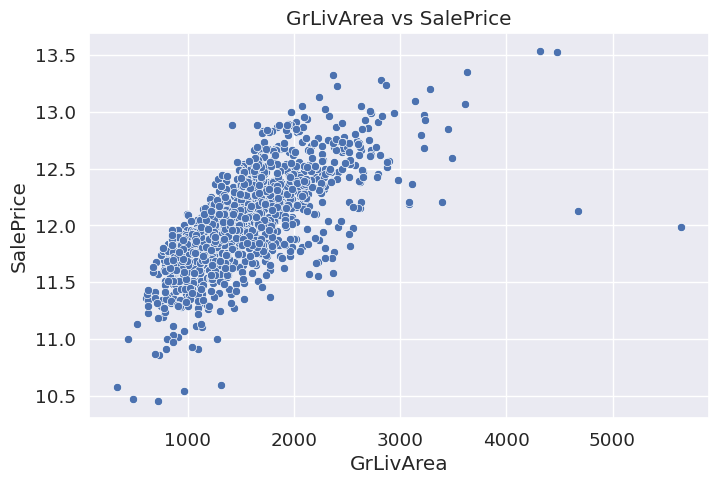

In [15]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(x=data_df["GrLivArea"], y=data_df["SalePrice"])
plt.title("GrLivArea vs SalePrice")

In [16]:
clear_data = data_df.drop(data_df[(data_df['GrLivArea']>4500)].index)
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

**GarageYrBlt feature**

Checking if there are records that YearBuilt or GarageYrBlt has years after 2017.

In [17]:
print("Is there YearBuilt more than 2017 ? : ", all_data[all_data.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", all_data[all_data.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [18]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo

2592    2207.0
Name: GarageYrBlt, dtype: float64

Replacing the Typo

In [19]:
all_data.loc[2592, 'GarageYrBlt'] = 2007

**LotFrontage feature**

LotFrontage is a linear feet of street connected to property. I think it is a high probability that these values are similar to houses in the same Neighborhood. I check some statistics for them.

In [20]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [21]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**Transformation of some numerical variables that are actually categorical.**

In [22]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [23]:
num_to_categ_features = ['MSSubClass', 'OverallCond']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

**Replacing missing values in the rest of numerical columns**

For the other numerical data I will also estimate them according to their statistics and for that I will use SimpleImputer object from sklearn library. For columns: BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath and BsmtHalfBath , MasVnrArea I will fill Nan values with constant = 0 and for the rest with median.

In [24]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

# Generating numerical features as input to DataFrameMapper.  
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)

**Categorical to numeral**

There is a lot of categorical features in data, so the next step is to transform them into numerical values.

In [25]:
cat_feats = all_data.select_dtypes(include=['object']).columns

According to data description (possible values for each feature) on Kaggle, I created a list of conversion values, specific for each column.

In [26]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

I implemented the none_transform function which converts missing categorical values into specific strings from the none_conversion dictionary.

In [27]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values 
    into specific strings according to "conversion_list" 
    
    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df
# Applying the "none_transform" function 
all_data = none_transform(all_data, none_conversion)
len(all_data.columns)

78

**Transformation of skewed features**

As for linear models preferable are normally distributed data, I am transforming the skewed features to make them more normally distributed.

In [28]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

In [29]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

**Categorical into Numerical**

As some categorical features (i.e. KitchenQual, GarageQual) can be transformed into the numerical values with some order, I also implemented a new encoder for them.

In [30]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

In [31]:
#Some Neighborhood seems to be more expensive than the others so..:

class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

In [32]:
#As I implemented previously specific transformers for categorical data, I will run the whole pipeline for them.

# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)
original_features_df.shape

(2919, 10)

In [33]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)
all_data.shape

(2919, 78)

# **Feature Engineering**
**Creating new features**

These features seem to be useful for house price prediction. As they are not contained in kaggle dataset I decided to create them from other informations.

"TotalSqrtFeet" - Total Live Area

"TotalBaths" - Total Area for Bathrooms

In [34]:
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)
# If the house has a garage
all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a fireplace
all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a pool
all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has second floor
all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Open Porch
all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Wood Deck
all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

**One-hot encoding**

In [35]:
all_data = all_data.drop(["SalePrice"], axis = 1) #Droping SalePrice column

#Converting the all_data Dataframe into a one hot encoded dataframe
hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

(2919, 324)

In [36]:
all_data = pd.concat([transformed_df, hot_one_features],axis=1)

**Splitting into train/test**

In [37]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


**Modelization**

In [38]:
X_train = train_preprocessed

In [39]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

In [40]:
#Defining scoring function

def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

In [41]:
#Linear Regression

lr_model = make_pipeline(RobustScaler(), LinearRegression()) #TODO: why Robust Scaler?

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00858436


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for Linear Regression: 17870.352


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


In [42]:
#GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}
                              
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=10)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [43]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000933


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.5s remaining:  1.3min


RMSE score for GB: 0.121


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [48]:
#XGB Regressor

xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.03],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Mean Squared Error = 0.00132712


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.5min remaining: 11.3min


RMSE score for XGB: 0.118


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min finished


In [45]:
#Tried Blending gb_model and xgb_model. But that didn't improve the result.

#from sklearn.metrics import mean_squared_error

#gb_preds = gb_model.predict(test_preprocessed)
#xgb_preds = xgb_model.predict(test_preprocessed)

# Create a meta-model (e.g., Random Forest Regressor)
#meta_model = RandomForestRegressor(random_state=42)

# Prepare data for meta-model
#meta_test_data = pd.DataFrame({"gb_preds": gb_preds, "xgb_preds": xgb_preds})
#meta_train_data = pd.DataFrame({"gb_preds": gb_model.predict(X_train), "xgb_preds": xgb_model.predict(X_train)})

# Train meta-model
#meta_model.fit(meta_train_data, y_train)

# Make final predictions using meta-model
#final_preds = meta_model.predict(meta_test_data)

In [49]:
#Decided to go with xgb_pred after many trials on test outcome using all the models
xgb_pred = xgb_model.predict(test_preprocessed)
submission = {'Id': test_preprocessed.index+1, 'SalePrice': np.expm1(xgb_pred)}
submission = pd.DataFrame(data=submission)
submission

,Id,SalePrice
0,1461,119412.632812
1,1462,160949.562500
2,1463,187165.750000
3,1464,192788.718750
4,1465,186614.656250
...,...,...
1454,2915,80536.203125
1455,2916,80149.414062
1456,2917,163149.140625
1457,2918,115442.671875


In [50]:
submission.to_csv('/kaggle/working/submission.csv', index=False)